### Notebook for the differential abundance analysis on mixed cell states using `milopy`

- **Developed by:** Carlos Talavera-López Ph.D
- **Institute of Systems Immunology (WüSI) - JMU-Würzburg**
- v230730

### Import required packages

In [1]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc 
import milopy.utils
import milopy.core as milo
import milopy.plot as milopl
import matplotlib.pyplot as plt

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.3
-----
PIL                 10.0.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
cffi                1.15.1
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
executing           1.2.0
google              NA
h5py                3.9.0
igraph              0.10.6
importlib_resources NA
ipykernel           6.25.0
ipywidgets          8.0.7
jedi                0.19.0
jinja2              3.1.2
joblib              1.3.1
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.39.1
markupsafe          2.1.3
matplotlib          3.7.2
milopy              0.1.1
mpl_toolkits        NA
mpmath              1.3.0
natsort             8.4.0
numba               0.56.4
numpy               1.23.5
opt_einsum          v3.3.0
packaging           23.1
pandas              2.0.0
parso               0.8.3
patsy               0.

### Read in data

In [3]:
adata = sc.read('../../../data/Epithelial_Mixed_states_locked_ctl230730.raw.h5ad')
adata

AnnData object with n_obs × n_vars = 12256 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states', 'seed_labels', 'Viral_score', 'C_scANVI_v2', 'mixed_states', 'cell_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'tota

### Visualise manifold

/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


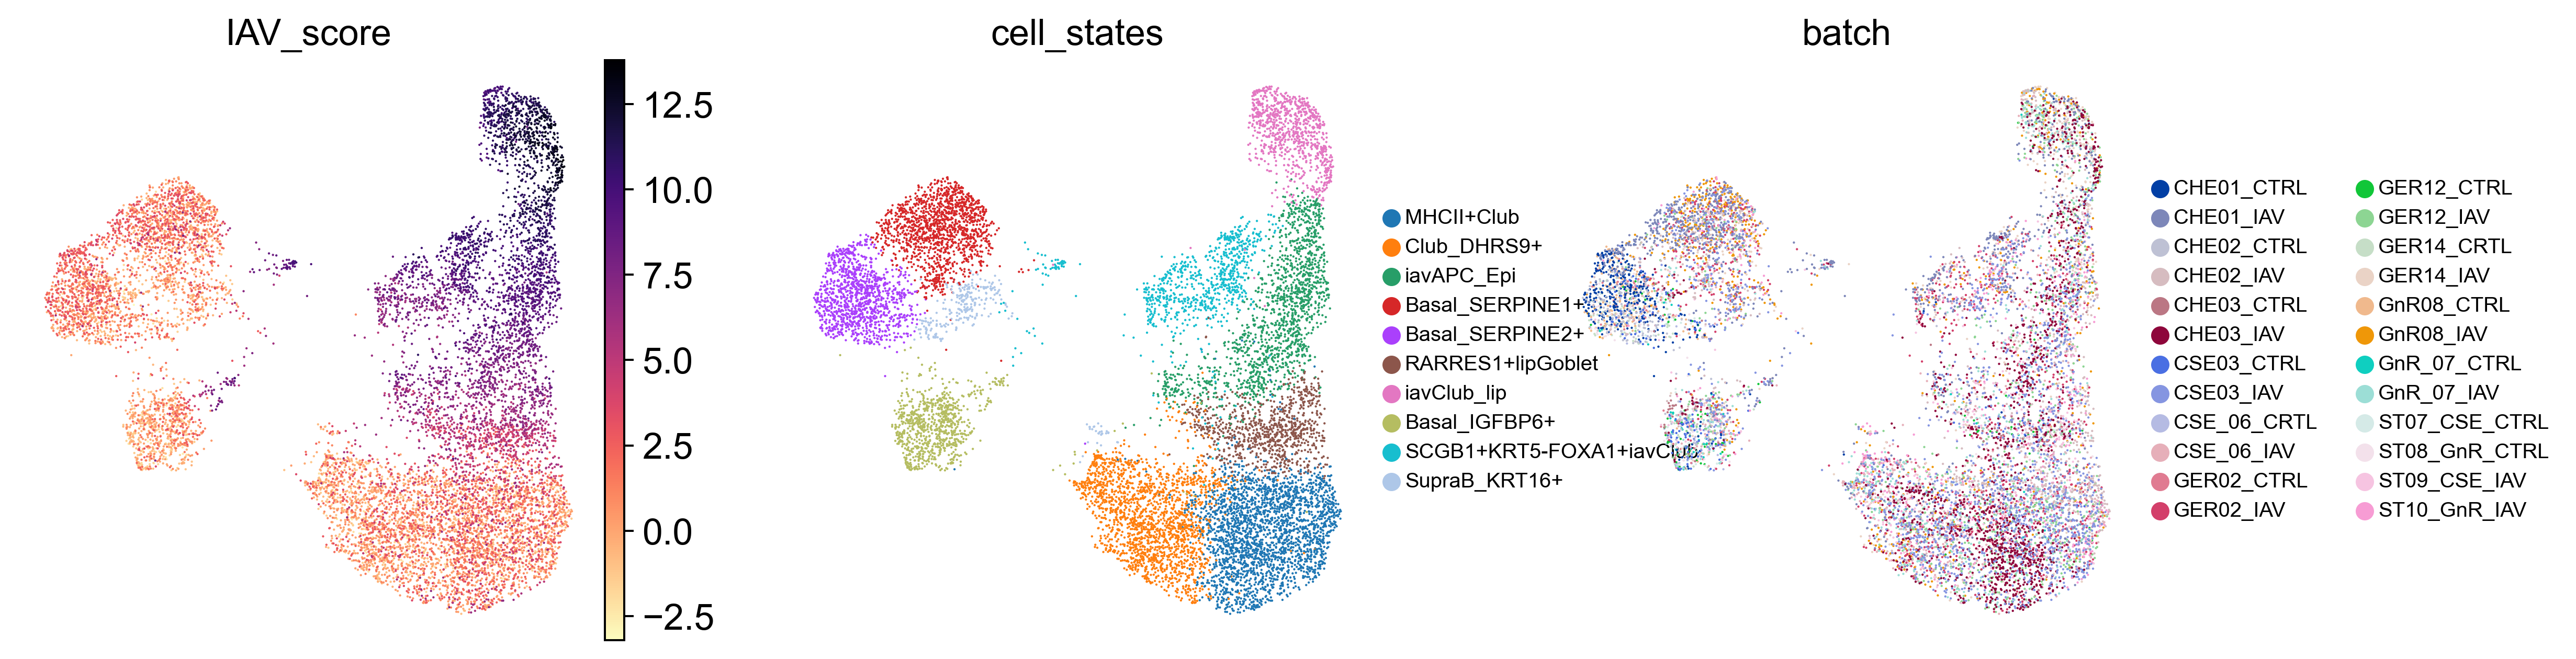

In [4]:
sc.pl.umap(adata, frameon = False, color = ['IAV_score', 'cell_states', 'batch'], size = 3, legend_fontsize = 8, ncols = 3)

In [5]:
adata.obs['group'].cat.categories

Index(['healthy_ctrl', 'healthy_iav', 'copd_ctrl', 'copd_iav'], dtype='object')

### Build k-NN graph

In [6]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 30, metric = 'minkowski', key_added = "milo")

computing neighbors


### Construct neighbourhoods

In [ ]:
milo.make_nhoods(adata, neighbors_key = "milo", prop = 0.1)
adata.obsm["nhoods"]

- The information on which cells are sampled as index cells of representative neighbourhoods is stored in adata.obs, along with the distance of the index to the kth nearest neighbor, which is used later for the SpatialFDR correction.

In [ ]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

- We can visualize the distribution of neighbourhood sizes to get an idea of the right value for k

In [ ]:
nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins = 120)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

In [ ]:
np.median(nhood_size)

In [ ]:
adata.obs['group'].cat.categories

In [ ]:
adata

### Count cells in neighbourhoods

In [ ]:
milo.count_nhoods(adata, sample_col = "batch")
adata.uns["nhood_adata"]

### Differential abundance testing with GLM

- We are now ready to test for differential abundance across groups. The experimental design needs to be specified with R-style formulas.

In [ ]:
adata.obs["group_continuous"] = adata.obs["group"].cat.codes

In [ ]:
milo.DA_nhoods(adata, design = "~group_continuous")

In [ ]:
adata.uns["nhood_adata"].obs.head()

In [ ]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [15,4]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins = 150);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [ ]:
milopy.utils.build_nhood_graph(adata)

In [ ]:
plt.rcParams["figure.figsize"] = [6,6]
milopl.plot_nhood_graph(adata, 
                        alpha = 0.4, 
                        min_size = 0.5 
                       )

### Visualise results by cell state

In [ ]:
adata.obs['cell_states'].cat.categories

In [ ]:
milopy.utils.annotate_nhoods(adata, anno_col = 'cell_states')

In [ ]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")